# Singapore Road Network Graph

The idea behind plotting this graph is that travelling from one point to another is simply not a straightline. Most of the Travelling Salesman Problem (TSP) out there are mainly visualised by the use case of travelling withing states, or inter-continental. For which, having a detailed route layout would only make a marginal difference in choosing its path, hence highly probable that it would yield a different result. However, since we are using Singapore as a use case, a land with area of less than 100km^2, using straightline would not makes the best sense.  

In this notebook, we will be exploring the construction of a Road Network Graph using the data from the data.gov.sg

This graph would be the base which pinpoints the underlying road structure and segments in Singapore.

Next task would involve:
 - Finding detailed data about each road
   - Speed limit
   - Travellable by bus
   - Assigning directional graph

These data are available at other government websites

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [2]:
pd.options.mode.chained_assignment = None

### Import data

In [3]:
geojson_raw = './data/national-map-line-geojson.geojson'
map_gpd = gpd.read_file(geojson_raw)

### EDA

In [4]:
display(map_gpd.head())
display(HTML(map_gpd["Description"][0]))

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85833 1.35595 0.00000, 103.8..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85759 1.35611 0.00000, 103.8..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.86042 1.36817 0.00000, 103.8..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85978 1.37228 0.00000, 103.8..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85937 1.36913 0.00000, 103.8..."


In [5]:
def plot_geojson(df, title, figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    df["geometry"].plot(ax=ax)
    plt.title(title)
    plt.show() 

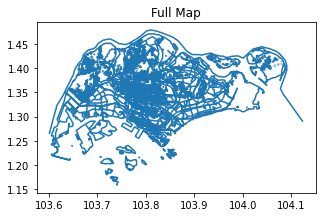

In [6]:
plot_geojson(map_gpd, "Full Map")

### Data Cleaning
Maps are too messy, including redundant landmarks that does not looks like a road

In [7]:
def extract_html_table(row):
    html = row["Description"]

    df = pd.read_html(html, index_col=0)[0]

    columns = pd.Series({
        "Street": df.loc["NAME"][0],
        "Folderpath": df.loc["FOLDERPATH"][0]
    })

    return pd.concat([
        row, columns
    ])

In [8]:
map_gpd = map_gpd.apply(extract_html_table, axis=1)
map_gpd = map_gpd.drop(columns=["Description"])

In [9]:
map_gpd.head()

,Name,geometry,Street,Folderpath
0,kml_1,"LINESTRING Z (103.85833 1.35595 0.00000, 103.8...",CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad
1,kml_2,"LINESTRING Z (103.85759 1.35611 0.00000, 103.8...",CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad
2,kml_3,"LINESTRING Z (103.86042 1.36817 0.00000, 103.8...",CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad
3,kml_4,"LINESTRING Z (103.85978 1.37228 0.00000, 103.8...",CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad
4,kml_5,"LINESTRING Z (103.85937 1.36913 0.00000, 103.8...",CENTRAL EXPRESSWAY,Layers/Expressway_Sliproad


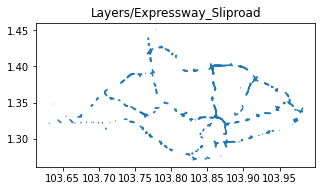

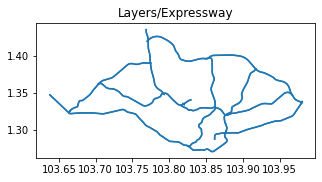

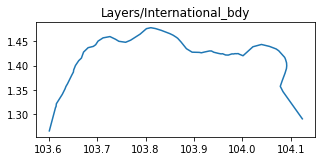

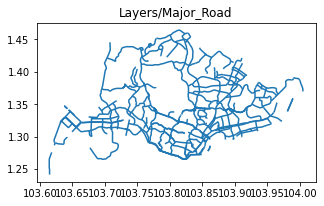

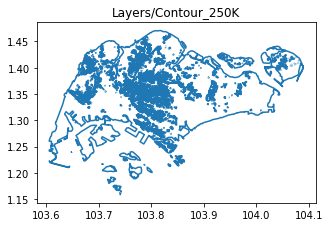

In [10]:
for map_type in map_gpd["Folderpath"].unique():
    map_type_gpd = map_gpd[map_gpd["Folderpath"] == map_type]
    plot_geojson(map_type_gpd, map_type)

#### EDA Findings

We want to persist Major Road and Expressway

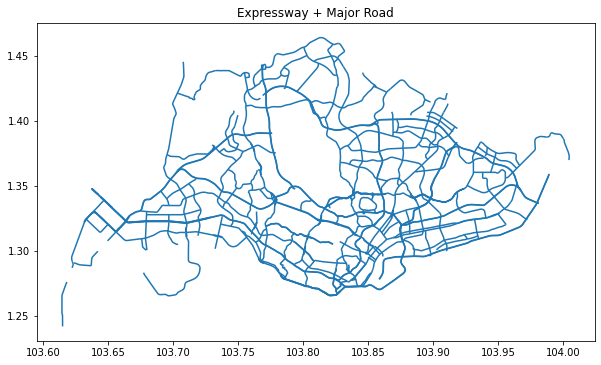

In [11]:
c1 = map_gpd["Folderpath"] == "Layers/Expressway"
c2 = map_gpd["Folderpath"] == "Layers/Major_Road"

map_clean = map_gpd[c1 | c2]

plot_geojson(map_clean, "Expressway + Major Road", (10, 10))

In [12]:
map_clean.to_file('./out/road.geojson', driver="GeoJSON")

#### Plot Path

In [13]:
import json
from shapely.geometry import Point

coords = json.load(open('./out/path.json'))["path"]

geometry = [Point(x) for x in coords]
geo_df = gpd.GeoDataFrame(geometry = geometry)

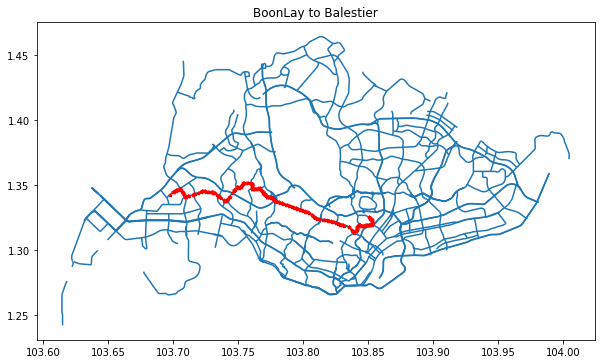

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
map_clean["geometry"].plot(ax=ax)
ax = geo_df.plot(ax = ax, markersize = 10, color = 'red',marker = '*', zorder=3)
plt.title("BoonLay to Balestier")
plt.show() 

#### Convert to GEOJSON to Graph

In [116]:
geojson_raw = './data/national-map-line-geojson.geojson'
geojson = json.load(open(geojson_raw))["features"]
geojson_df = pd.DataFrame.from_records(geojson)
geojson_df = geojson_df.drop(columns=["type"])

In [117]:
geojson_df["Description"] = geojson_df["properties"].apply(lambda x: x["Description"])
geojson_df = geojson_df.drop(columns=["properties"])

geojson_df = geojson_df.apply(extract_html_table, axis=1)
geojson_df = geojson_df.drop(columns=["Description"])

In [118]:
expressway_df = geojson_df[geojson_df["Folderpath"] == "Layers/Expressway"]
map_expressway = map_gpd[map_gpd["Folderpath"] == "Layers/Expressway"]

In [119]:
expressway_df["coordinates"] = expressway_df["geometry"].apply(lambda x: x["coordinates"])
expressway_df = expressway_df.drop(columns=["geometry"])

In [120]:
def extract_coordinate(row):
    longitude, latitude, elevation = row["coordinates"]

    return pd.concat([
        row, pd.Series({
            'longitude': longitude,
            'latitude': latitude
        })
    ])

In [121]:
expressway_df = expressway_df.explode("coordinates")

In [122]:
expressway_df = expressway_df.apply(extract_coordinate, axis=1)
expressway_df = expressway_df.drop(columns=["coordinates"])

In [123]:
road_intersects = expressway_df.groupby(["longitude", "latitude"])["Street"].count()
road_intersects = road_intersects[road_intersects > 1]

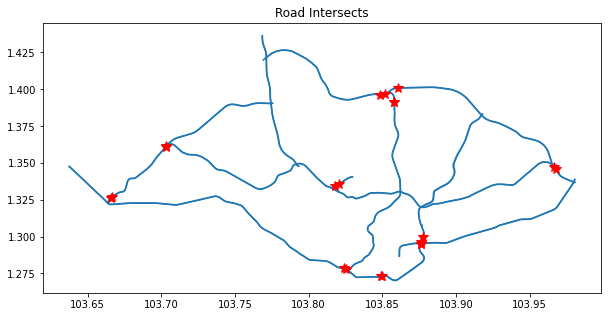

In [124]:
fig, ax = plt.subplots(figsize=(10, 10))
map_expressway["geometry"].plot(ax=ax)

for coordinate, intersect_count in road_intersects.items():
    lon, lat = coordinate
    plt.plot(lon, lat, markersize = 10, color = 'red',marker = '*', zorder=3)

plt.title("Road Intersects")
plt.show()

#### Findings

Some roads intersections are not being detected. Lets try clubbing the coordinate matrix to a more sparse dimensional space

In [194]:
# import math
# import decimal

def truncate_mantissa(coord, point):
    coord = round(coord, point)
    return coord

# def round_to_even(coord):
#     coord_str = str(coord)
#     mantissa_tail = float(coord_str[-1])
#     mantissa_length = len(str(coord_str)) - 2

#     if (mantissa_tail % 2 != 0):
#         coord += round(math.pow(0.1 , mantissa_length), mantissa_length)

#     return coord


def round_coordinate(coord, point):
    coord_str = str(coord)
    exponent_str, mantissa_str = coord_str.split('.')
    mantissa = int(mantissa_str)

    mantissa_rounded = mantissa - (mantissa % point)
    rounded_str = f'{exponent_str}.{mantissa_rounded}'

    return round(float(rounded_str), len(mantissa_str))

In [231]:
rounded_expressway_df = expressway_df.copy()

In [232]:
rounded_expressway_df["longitude"] = rounded_expressway_df["longitude"].apply(lambda x: truncate_mantissa(x, 5))
rounded_expressway_df["latitude"] = rounded_expressway_df["latitude"].apply(lambda x: truncate_mantissa(x, 5))

In [233]:
rounded_expressway_df["longitude"] = rounded_expressway_df["longitude"].apply(lambda x: round_coordinate(x, 25))
rounded_expressway_df["latitude"] = rounded_expressway_df["latitude"].apply(lambda x: round_coordinate(x, 25))

In [234]:
rounded_expressway_df.head()

,Street,Folderpath,longitude,latitude
200,LORNIE HIGHWAY,Layers/Expressway,103.82050,1.33575
200,LORNIE HIGHWAY,Layers/Expressway,103.82025,1.33550
200,LORNIE HIGHWAY,Layers/Expressway,103.82000,1.33550
200,LORNIE HIGHWAY,Layers/Expressway,103.81850,1.33475
200,LORNIE HIGHWAY,Layers/Expressway,103.81825,1.33450


In [235]:
road_intersects = rounded_expressway_df.groupby(["longitude", "latitude"])["Street"].count()
road_intersects = road_intersects[road_intersects > 1]
print(road_intersects.shape)

(183,)


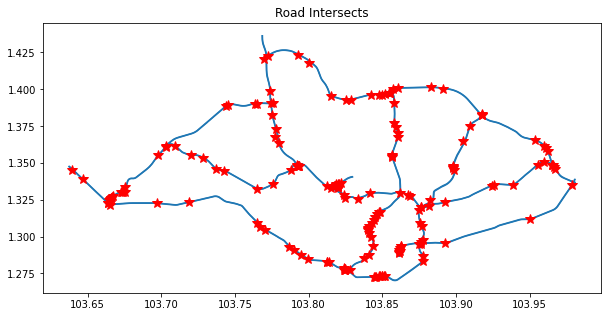

In [236]:
fig, ax = plt.subplots(figsize=(10, 10))
map_expressway["geometry"].plot(ax=ax)

for coordinate, intersect_count in road_intersects.items():
    lon, lat = coordinate
    plt.plot(lon, lat, markersize = 10, color = 'red',marker = '*', zorder=3)

plt.title("Road Intersects")
plt.show()